# Determining Water Potability

## Introduction

Water potability is critical for supporting populations, various industries and agricultural activities that rely on clean water for survival. Clean and drinkable water can be determined by careful analysis of certain characteristics of a sample. Using classification we hope to train a data set to be able to classify water as safe or not based on its characteristics. The question we will be asking is: Does the water sample meet potability standards considering its various levels and characteristics?
The data set we will be using is ‘Water Quality and Potability’. Each observation has a pH value, total solids dissolved, chloramines count, sulfate count, conductivity, organic carbon level, trihalomethanes, turbidity and potability. With these values we hope to provide accurate results on potability. 
This data set is from Kaggle, a cite that provides a multitude of data sets open to the public. This data set was originally sourced from GitHub, the URL to this specific data set on GitHub is https://github.com/MainakRepositor/Datasets/blob/master/water_potability.csv. 


## Reading in the Data

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


#reading the data set from the web 
water <- read_csv("https://raw.githubusercontent.com/nori-2004/data-science-group-project/main/water_potability.csv")


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## Cleaning and Wrangling

In [2]:
set.seed(1234)
#changing the potable variable to a factor datatype
water<- water |> 
    mutate(Potability = as_factor(Potability))

#removing missing values 
initial_rows <- nrow(water)

water <- na.omit(water)

final_rows <- nrow(water)

removed_rows <- initial_rows - final_rows

#cleaning the data by selecting the columns we want to use
water_selected <- select(water, - Conductivity)


In [3]:
#splitting the data into testing and training sets
water_split <- initial_split(water_selected, prop = 0.75)
water_train <- training(water_split)   
water_test <- testing(water_split)

## Summary Tables

In [4]:
#counting the number of observations that are potable and not potable

water_count<-water_train|>
    group_by(Potability)|>
    summarize(count=n())
water_count

print("number of rows removed were")
removed_rows

# Count available data for each column
available_data_counts <- map_df(water_train, ~sum(!(is.nan(.x)|is.na(.x))))
print("Available data counts (non-available data was removed)")
available_data_counts

# portable: not or able
portability_table <- table(water_train$Potability)
print("Potability table: 0 for not and 1 for able")
portability_table

# Calculate the ratio of portable vs non portable data
portability_ratio <- portability_table[2] / portability_table[1]
print("Probability ratio - the probability of the water sample to be not potable")
portability_ratio

# Select just the predictors
water_train_predictors = select(water_train, -Potability)

# Means of the predictors
predictor_means <- colMeans(water_train_predictors, na.rm = TRUE)
print("Means of the predictors")
predictor_means

Potability,count
<fct>,<int>
0,892
1,616


[1] "number of rows removed were"


[1] 1265

[1] "Available data counts (non-available data was removed)"


ph,Hardness,Solids,Chloramines,Sulfate,Organic_carbon,Trihalomethanes,Turbidity,Potability
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1508,1508,1508,1508,1508,1508,1508,1508,1508


[1] "Potability table: 0 for not and 1 for able"



  0   1 
892 616 

[1] "Probability ratio - the probability of the water sample to be not potable"


1 
0.690583

[1] "Means of the predictors"


ph        Hardness          Solids     Chloramines         Sulfate 
       7.105768      195.732508    21855.236205        7.129208      334.074007 
 Organic_carbon Trihalomethanes       Turbidity 
      14.360075       66.068931        3.962126

## Graphs 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


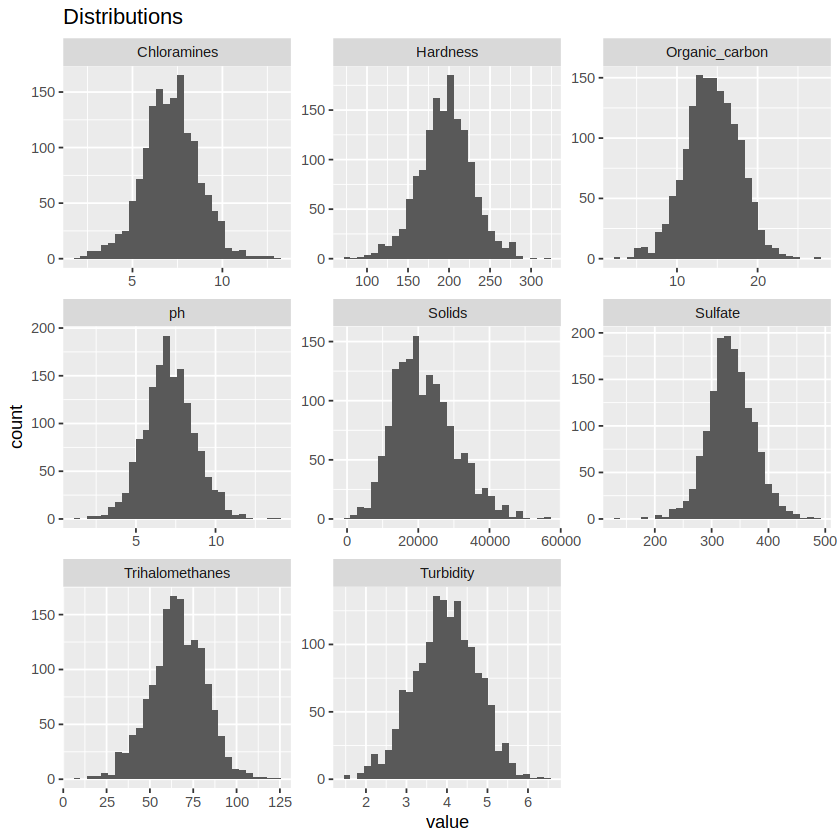

In [5]:
# Exploratory Graphs for the predictors

# Distributions
water_train_predictors |>
    gather(variable, value) |>
    ggplot(aes(x = value)) +
    geom_histogram() +
    facet_wrap(~ variable, scales = "free") +
    ggtitle("Distributions")


## Methodology

The problem that we have selected is a classification problem, i.e. classifying a sample of water into potable or non-potable. We will be using the K nearest neighbour classification do to so. Out of the 8 variables in our dataset, we will be using all of them as predictors besides conductivity. First, we shall prepare the data by tidying it and splitting it into training an testing sets. Then we will use cross-validation to pick the best “k” value for our dataset and then train the model using the training set, and then apply it to the testing set. This will ensure that we produce a classifier with the highest accuracy possible. Though, it would be ideal to have high precision and high recall, we shall be aiming to have a high recall with not-potable being the “positive” class. 


The best way in this case to visualize our result is to create several scatterplots using pairs of variables, this will also highlight any hidden co-relations between them. We will be experimenting with our visuals to avoid overplotting since there are over 900 observations in our data set. This will be done either by reducing the size or the transparency of the points.



## Performing the analysis 

**which $k$ should we use?**

Below we we will be doing the following: 
- Creating a recipe that uses all predictors (besides conductivity).
- Creating a model specification with tuning on the number of neighbours.
- Performing a 10-fold cross-validation 
- Plotting a graph of $k$ vs the accuracy to determining the $k$ with the highest accuracy for our data set. 

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


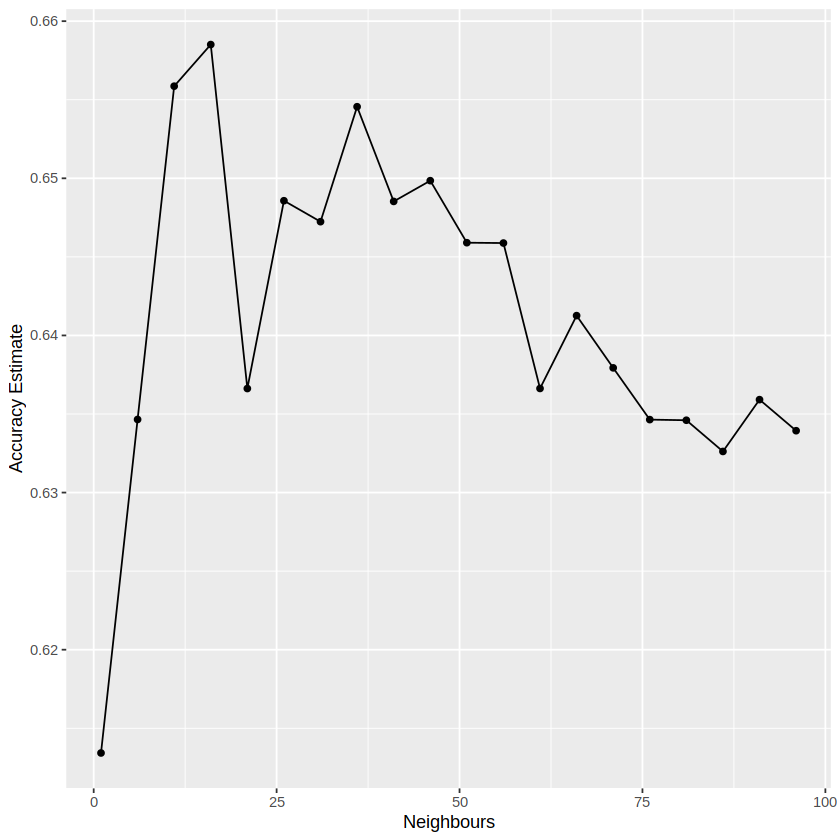

In [6]:
## creating the recipe and scaling and centering all predictors 
water_recipe <- recipe(Potability ~ . , data = water_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")


k_vfold <- vfold_cv(water_train, v = 10, strata = Potability)

knn_workflow <- workflow() |>
    add_recipe(water_recipe)|>
    add_model(knn_spec)

knn_workflow

## testing k values from 5 to 20 
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- knn_workflow |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_validation_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbours", y = "Accuracy Estimate")

cross_validation_plot

## Outcomes and Significance 

We expect to find the ranges of each variable which are required for the water to be portable. Based on the strict maintenance of quality-determining variables needed for clean water, we expect a minimal range of variance between portable classified samples. Meanwhile, there is predicted to be a greater spread of data that falls in the non-portable range. 
The classification of water potability (water that is suitable for human consumption) is essential for evaluating water supplies around the world. The data model can be used to identify non-portable classified samples which can be further analyzed based on deviation from different portable water variables. This serves as a gateway to the analysis of water samples in specific industries. For instance, water samples with a higher turbidity than that of portable samples ( which indicate higher levels of microorganisms such as bacteria and parasites)  can be sent over to microbiological labs for further analysis. 
This leads to a plethora of other questions that can be explored, such as specific wastewater treatments based on the type of contamination (ie. sulfate, pH levels, etc.). Our findings could be further analyzed using calculation based questions such as the average amount of chloramines used in potable water.